# Dive Prediction - First Time Passage

*Predicting Seabird Diving Behaviour from GPS data*

This notebook predicts dive with First Time Passage Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.trip import * 

In [2]:
data_test = pd.read_csv('./data/data_test.csv')

## Choose resolution

In [52]:
## 
resolution = 60

In [53]:
data_test_new = pd.DataFrame() 
for i in data_test.trip.unique():
    t = data_test[data_test.trip == i].copy()
    
    idx = [i%resolution == 0 for i in range(len(t))]
    
    traj = t.loc[idx, ('trip', 'datetime', 'lon', 'lat')]
    
    traj['dive'] = [np.max(t.dive[i:i+resolution]) for i in range(len(t)) if i%resolution==0]
    
    data_test_new = data_test_new.append(traj, ignore_index=True)

#### check if it is coherent with R code for HMM

In [54]:
hmm = pd.read_csv('./results/hmm_prediction_'+str(resolution)+'s.csv')

In [55]:
sum(1-(hmm.dive == data_test_new.dive))

0

## Empirical parameters 

In [56]:
## compute distance matrixes
list_trip = []
for i in data_test_new.trip.unique():
    t = data_test_new[data_test_new.trip == i]
    
    trip = Trip(t)
    trip.compute_dist_matrix()
    list_trip.append(trip)

In [57]:
## compute first time passage
radius = 500

list_ftp = []
for trip in list_trip:
    ftp = trip.first_time_passage(radius)
    list_ftp.append(ftp/max(ftp))

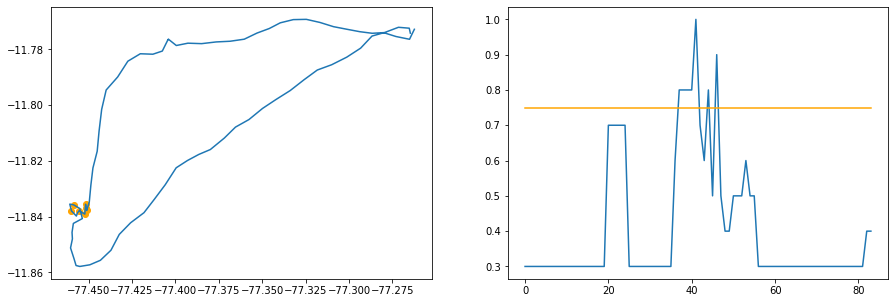

In [58]:
time_threshold = 0.75

i = 0

trip = list_trip[i]
ftp = list_ftp[i]

plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.plot(np.array(trip.df.lon), np.array(trip.df.lat))
plt.scatter(trip.df.lon.values[ftp>time_threshold], \
            trip.df.lat.values[ftp>time_threshold], c = 'orange')

plt.subplot(1,2,2)
plt.plot(ftp)
plt.plot(time_threshold*np.ones(len(ftp)), c = 'orange')

In [59]:
data_test_new['prediction'] = np.hstack(list_ftp)
data_test_new.to_csv('./results/ftp_prediction_'+str(resolution)+'s.csv', index = False)

# HMM ROC for different resolutions

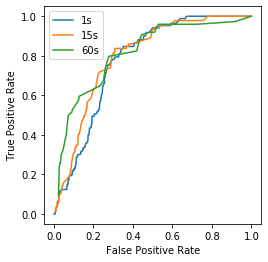

In [64]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

for res in [1, 15, 60]:
    
    data = pd.read_csv('./results/ftp_prediction_'+str(res)+'s.csv')
    
    # globally
    TP = []
    FP = []

    real =  data.dive  
    for tt in np.arange(0, 1, 0.001):
        estim = 1* (data.prediction > tt)
        true_positive = np.mean(estim[real == 1])
        true_negative = 1-np.mean(estim[real == 0])
        TP.append(true_positive)
        FP.append(1-true_negative)
        
    plt.plot(FP, TP, label = str(res)+'s')
    
plt.legend()